# t-SNE Visualization on Amazon Food Review Dataset

## Import Required Modules

In [1]:
import os # for file management
import shutil # for file management
from pathlib import Path # for file management
import sqlite3
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time # for time measurement
import imageio # for GIF creation

from sklearn.feature_extraction.text import CountVectorizer # for Bag Of Words
from sklearn.feature_extraction.text import TfidfVectorizer # for text to vector creation
from gensim.models import Word2Vec

from sklearn.preprocessing import StandardScaler # for Column Standardization - DO WE NEED THIS?
from sklearn.manifold import TSNE # for t-SNE

In [2]:
## Configure Matplotlib for nice image in PDF
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.figsize'] = 10,6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8

In [3]:
# All the outputs generated by this notebook will be placed in separate folder
output_dir = 'Output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Load Data

In [4]:
# Loading all the reviews from the database
# cleaned.sqlite already has reviews of 1,2,4,5 ratings only (also changed to +ive/-ive)
con = sqlite3.connect('./cleaned.sqlite')

df = pd.read_sql_query("""SELECT * from Reviews""", con)
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [5]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,364106.000000,364106.000000,364106.000000,364106.000000,364106.000000,3.641060e+05
mean,261221.056821,282777.564772,1.738411,2.186231,0.843164,1.296157e+09
std,152361.122483,164601.735167,6.716471,7.339767,0.363647,4.859821e+07
min,0.000000,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,129625.250000,140699.250000,0.000000,0.000000,1.000000,1.270858e+09
50%,257307.500000,278947.500000,0.000000,1.000000,1.000000,1.311379e+09
75%,396338.750000,428557.750000,2.000000,2.000000,1.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.000000,1.351210e+09


In [6]:
df.dtypes

index                      int64
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
CleanedText               object
dtype: object

In [7]:
# Split data
# positive review score, negative review score and review text as seperate dataframes
df_text = df['CleanedText']
print(df_text.shape)
df_text.head()

(364106,)


0    b'witti littl book make son laugh loud recit c...
1    b'grew read sendak book watch realli rosi movi...
2    b'fun way children learn month year learn poem...
3    b'great littl book read nice rhythm well good ...
4    b'book poetri month year goe month cute littl ...
Name: CleanedText, dtype: object

In [8]:
# Procedure of t-SNE generation is same for all types of vector analysis
# So creating a common function to generate t-SNE visualization
# using passed values

def genTSNEGif(std_data, ndp, p, itr_list, file_prefix, closePlt=False):
    '''
    Fuction which genrate t-SNE visualtion for each itr_list using given ndp and p
    Generates a GIF and stores it under '{img_name}.gif'
    Where:
        std_data - Column Standardized Data
        ndp - Number of Data Points to consider in std_data
        p - Perplexity
        itr_list - List of iterations, each iteration will be a frame in GIF
        file_prefix - Prefix to the name of GIF image
        closePlt - If you do not want to display the generated image in Notebook
    '''
    image_name = '{0}_tsne_ndp_{1}_p_{2}.gif'.format(file_prefix,ndp,p)
    print('No.Of Data Points - {0}, Perplexity - {1}, Iterations - {2}, ImageName - {3}'.format(
            ndp, p, itr_list, image_name))
    
    # list to hold the frames
    frames = []
    p_data = std_data
    p_labels = final_reviews_scores[0:ndp]
    
    #print('t-SNE Data Points {0} and its Labels {1}'.format(p_data.shape, p_labels.shape))
    for itr_val in itr_list:
        img_title = '{0}-ndp={1} p={2} itr={3}'.format(file_prefix, ndp, p, itr_val)
        
        time_start = time.time()
        
        model = TSNE(n_components=2,random_state=0,perplexity=p,n_iter=itr_val) # ,verbose=2
        tsne_data = model.fit_transform(p_data)
        time_elapsed = time.time() - time_start
        print('{0} ==> t-SNE done! Time elapsed: {1} seconds'.format(img_title, time.time() - time_start))
    
        tsne_data = np.vstack((tsne_data.T,p_labels)).T
        #print(tsne_data.shape)
        #tsne_data[:4]
        tsne_df = pd.DataFrame(tsne_data,columns=['Dim_1','Dim_2','Score'])
        #tsne_df.head()
        g = sns.FacetGrid(tsne_df,hue='Score',height=10).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend();
        g.fig.suptitle(img_title);
        g.fig.canvas.draw();
        image = np.frombuffer(g.fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(g.fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        
        if (closePlt == True):
            plt.close()
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave(Path.cwd() / output_dir / image_name, frames, fps=1)
    
    return

## Training Data for Visualization - 2K Points

In [9]:
# we can't process all 364K revies, selecting a subset of it
total_data_set_size = 2000

# Create a Balanced dataset having both +ive and -ive reviews
df_positive_reviews = df[df.Score == 1].sample(int(total_data_set_size/2))
df_negative_reviews = df[df.Score == 0].sample(int(total_data_set_size/2))

final_reviews = pd.concat([df_positive_reviews, df_negative_reviews])
final_reviews_scores = final_reviews['Score']

print('Shape of Training Data {0}'.format(final_reviews.shape))
print('Shape of Training Label {0}'.format(final_reviews_scores.shape))

Shape of Training Data (2000, 12)
Shape of Training Label (2000,)


In [10]:
final_reviews.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
160283,202154,219052,B001CRAWCQ,A15C0QFMZ6JTE1,Ivana Pandurovic,1,2,1,1303344000,LOVE Illy cafecito,"i am european, addicted not only to coffee but...",b'european addict coffe good coffe illi best c...
350384,44522,48450,B006H34CUS,A1C935N5QX5S4S,Jamie Radcliff,0,0,1,1346716800,Not too bad,I received a sample of this from Influenster a...,b'receiv sampl influenst pretti excit tri inte...
32515,178397,193447,B000BBDZ82,A3CZNNTEY657TE,"C. Gardner ""SgtCheeseNOLS""",1,1,1,1325462400,LOVE IT!,I first tried this tea at my day spa I go to f...,b'first tri tea day spa massag delici tea comp...
60680,17311,18879,B000F4H5FY,A2434W0L2ZL5X1,Brian,0,0,1,1291507200,Pretty good! Great Price!,I am aware that tea bags do not give the same ...,b'awar tea bag give flavour looseleaf stuff st...
43145,381893,412923,B000E4C2LW,A3TXDO9392M8NJ,"Beth Mitchum ""Ultravioletlove.com""",1,1,1,1275350400,Good Stuff at a Great Price,I know what you're thinking. Corn flakes are ...,b'know your think corn flake corn flake right ...


# Bag of Words (BoW)

In [11]:
# Create Vectors
count_vect = CountVectorizer(ngram_range=(1,2)) # create an instance
final_counts = count_vect.fit_transform(final_reviews['CleanedText'].values)
print('Shape of BoW Vectorizer: ', final_counts.get_shape())
print('Total no.of unique words: ', final_counts.get_shape()[1])

# Standardize the Data
standardized_data = StandardScaler().fit_transform(final_counts.toarray().astype(np.float64)) #, with_mean=False
print('Shape of Standardized data', standardized_data.shape)

Shape of BoW Vectorizer:  (2000, 66148)
Total no.of unique words:  66148
Shape of Standardized data (2000, 66148)


No.Of Data Points - 2000, Perplexity - 30, Iterations - range(3000, 3001, 1000), ImageName - BoW-std_tsne_ndp_2000_p_30.gif
BoW-std-ndp=2000 p=30 itr=3000 ==> t-SNE done! Time elapsed: 598.4183218479156 seconds


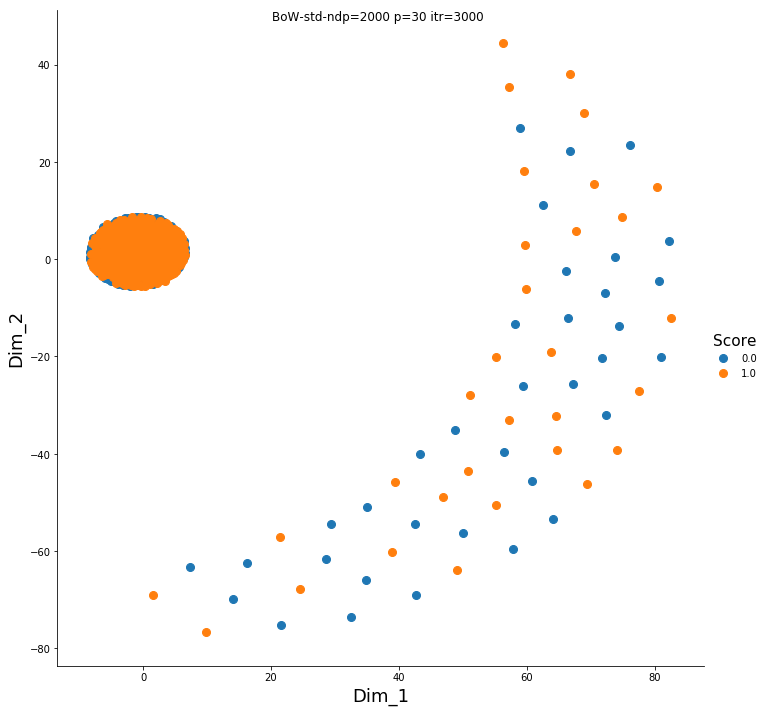

In [12]:
# Generating t-SNE for BoW
genTSNEGif(standardized_data, len(standardized_data), 30, range(3000,3001,1000), 'BoW-std')

# For various iterations I use below looping
#dense_mat = final_counts.toarray().astype(np.float64)
#for p in range(10, 101, 10):
#    genTSNEGif(dense_mat, len(dense_mat), p, range(1000,5001,1000), 'BoW',closePlt=True)

# TFIDF

In [13]:
# Create Vectors

tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
final_counts = tf_idf_vec.fit_transform(final_reviews['CleanedText'].values)

#.fit_transform(final_reviews['CleanedText'].values)
print('Shape of BoW Vectorizer: ', final_counts.get_shape())
print('Total no.of unique words: ', final_counts.get_shape()[1])

# Standardize the Data
standardized_data = StandardScaler().fit_transform(final_counts.toarray().astype(np.float64)) #, with_mean=False
print('Shape of Standardized data', standardized_data.shape)

Shape of BoW Vectorizer:  (2000, 66148)
Total no.of unique words:  66148
Shape of Standardized data (2000, 66148)


No.Of Data Points - 2000, Perplexity - 30, Iterations - range(3000, 3001, 1000), ImageName - tfidf-std_tsne_ndp_2000_p_30.gif
tfidf-std-ndp=2000 p=30 itr=3000 ==> t-SNE done! Time elapsed: 599.3038096427917 seconds


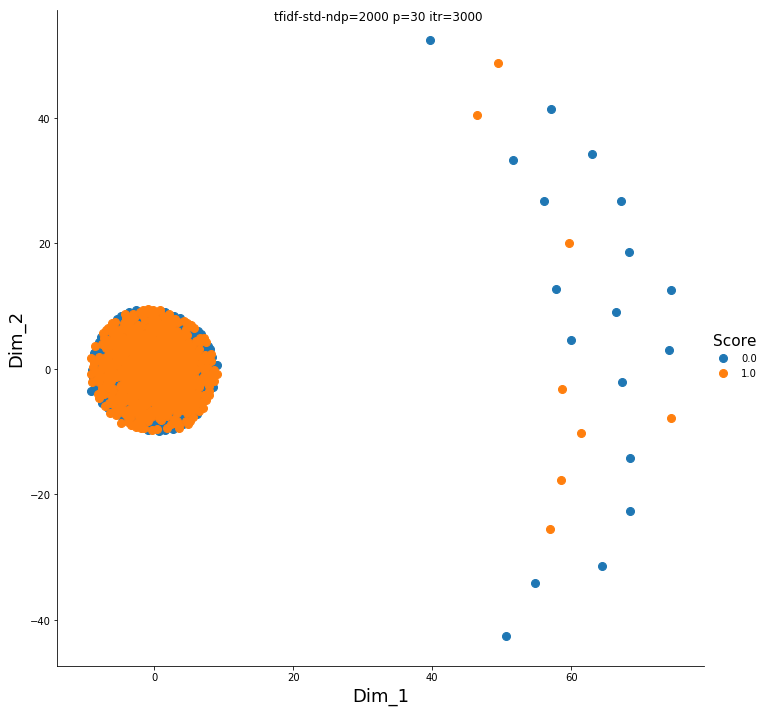

In [14]:
genTSNEGif(standardized_data, len(standardized_data), 30, range(3000,3001,1000), 'tfidf-std')

# For finding optimal perplexity and iteration, I execute below loop
#dense_mat = final_counts.toarray().astype(np.float64)
#for p in range(10, 61, 10):
#    genTSNEGif(dense_mat, len(dense_mat), p, range(1000,6001,1000), 'tfidf',closePlt=True)

# Word2Vec

I am creating vectors having 50 dimensions.
Just a random value, not inherent calculation I made on this size decision.

In [15]:
# Create List arry for creating own W2V
list_of_sent = []
for sent in final_reviews['CleanedText'].values:
    list_of_sent.append(sent.decode("utf-8").split())
    
print(final_reviews.CleanedText.values[0])
print(len(list_of_sent), list_of_sent[0])

b'european addict coffe good coffe illi best cant start day without illi espresso doubl one'
2000 ['european', 'addict', 'coffe', 'good', 'coffe', 'illi', 'best', 'cant', 'start', 'day', 'without', 'illi', 'espresso', 'doubl', 'one']


In [16]:
# Required dimension
w2v_d = 50

# Considering words that are occured atleast 5 times in the corpus
w2v_model = Word2Vec(list_of_sent, min_count=5, size=w2v_d, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times : ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times :  2017
sample words  ['addict', 'coffe', 'good', 'illi', 'best', 'cant', 'start', 'day', 'without', 'espresso', 'doubl', 'one', 'receiv', 'sampl', 'pretti', 'excit', 'tri', 'interest', 'concept', 'tast', 'thought', 'like', 'banana', 'bread', 'odd', 'textur', 'seem', 'bit', 'dri', 'though', 'rate', 'four', 'five', 'star', 'first', 'tea', 'delici', 'complaint', 'requir', 'tabl', 'spoon', 'make', 'cup', 'lot', 'mean', 'buy', 'bag', 'futur', 'awar', 'give']


## Avg-W2V

In [17]:
# Computing average w2v for each review in selected training dataset
review_vectors = []
for sent in tqdm(list_of_sent, ascii=True):
    sent_vec = np.zeros(w2v_d) # array to hold the vectors. Initially assuming no vectors in this review
    no_of_words_in_review = 0 # number of words with valid vector in this review
    
    # count all the words (that are in w2v model) and take average
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            no_of_words_in_review += 1
    if no_of_words_in_review != 0:
        sent_vec /= no_of_words_in_review
    review_vectors.append(sent_vec)
    
print(len(review_vectors))
print(len(review_vectors[0]))

100%|##########| 2000/2000 [00:02<00:00, 733.21it/s]

2000
50


No.Of Data Points - 2000, Perplexity - 70, Iterations - range(3000, 3001, 1000), ImageName - avg-w2v_tsne_ndp_2000_p_70.gif
avg-w2v-ndp=2000 p=70 itr=3000 ==> t-SNE done! Time elapsed: 56.379451274871826 seconds


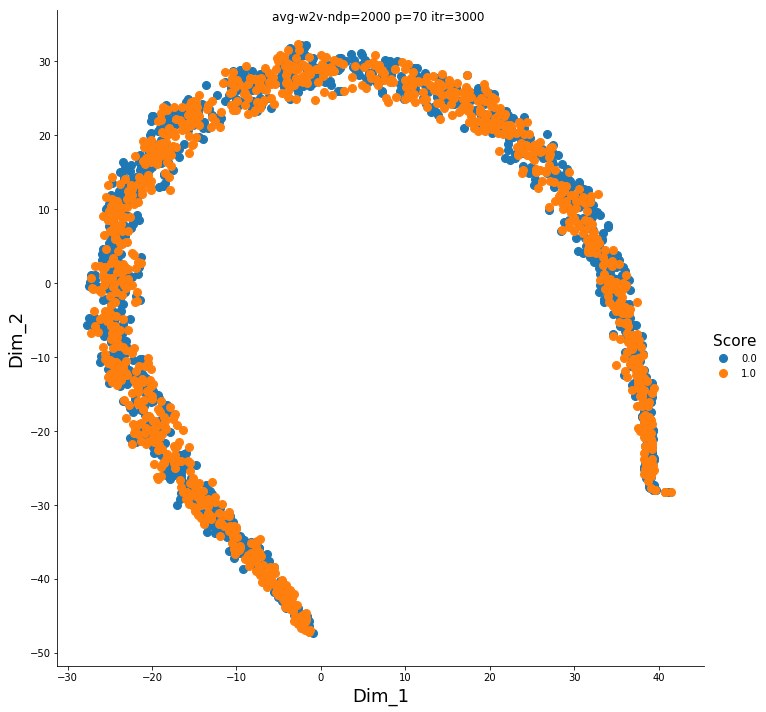

In [18]:
# t-SNE using Average Word2Vec

genTSNEGif(review_vectors, len(review_vectors), 70, range(3000,3001,1000), 'avg-w2v')

# for finding perplexity and iteration, I use below loop
#for p in range(10, 101, 10):
#    genTSNEGif(review_vectors, len(review_vectors), p, range(1000,5001,1000), 'avg-w2v',closePlt=True)

## TFIDF Weighted W2V

Computing tfidf weighted w2v over the selected training dataset

In [19]:
# Create tf-idf vector matrix
tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
tf_idf_matrix = tf_idf_model.fit_transform(final_reviews['CleanedText'].values)

# Create dictionary having words (features) as keys, its tf-idf values as values
tf_idf_dict = dict(zip(tf_idf_model.get_feature_names(), list(tf_idf_model.idf_)))
len(tf_idf_dict)

66148

In [20]:
tf_idf_feat = tf_idf_model.get_feature_names()

# Computing tf-idf weighted w2v for each review in selected training dataset
review_vectors = []
for sent in tqdm(list_of_sent, ascii=True):
    sent_vec = np.zeros(w2v_d) # array to hold the vectors
    no_of_words_in_review = 0 # number of words with valid vector in this review
    
    # count all the words (that are in w2v model) and take average
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # calculate tf-idf weighted w2v value for this word
            tf_idf = tf_idf_dict[word] * (sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            no_of_words_in_review += 1
    if no_of_words_in_review != 0:
        sent_vec /= no_of_words_in_review
    review_vectors.append(sent_vec)
    
print(len(review_vectors))
print(len(review_vectors[0]))

100%|##########| 2000/2000 [00:03<00:00, 563.31it/s]

2000
50


No.Of Data Points - 2000, Perplexity - 80, Iterations - range(3000, 3001, 1000), ImageName - tfidf-weighted-w2v_tsne_ndp_2000_p_80.gif
tfidf-weighted-w2v-ndp=2000 p=80 itr=3000 ==> t-SNE done! Time elapsed: 52.13369131088257 seconds


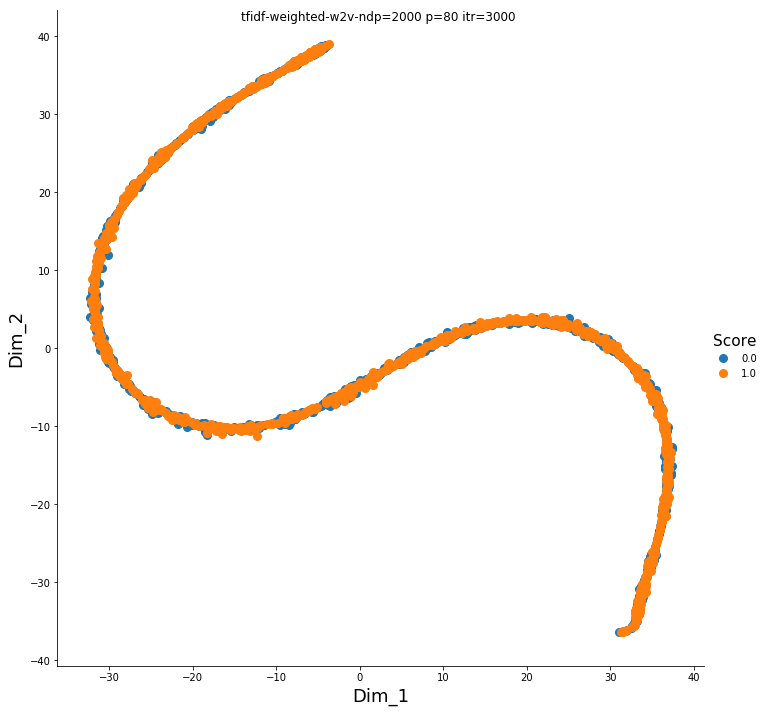

In [21]:
# t-SNE using tf-idf weighted s2v

genTSNEGif(review_vectors, len(review_vectors), 80, range(3000,3001,1000), 'tfidf-weighted-w2v')

#for p in range(10, 101, 10):
#    genTSNEGif(review_vectors, len(review_vectors), p, range(1000,5001,1000), 'tfidf-weighted-w2v',closePlt=True)

# t-SNE Observation

Due to memory limitation, only 2000 reviews out of 364K reviews of Amazon Fine Food Review has been taken

Created a Balanced dataset having 1000 positive and negative reviews respectively.

Generated t-SNE 2-D visualization from the vectors created with 1) Bag of Words, 2) TF-IDF, 3) Average Word 2 Vec and 4) TF-IDF Weighter Word2Vec.

I have generated my own Word2Vec from those 2K reviews having dimensionve of 50

- Both BoW and TF-IDF generated a small circled image, having both Positive and Negative reviews overlapped in same place
    - There are some outliers kind of observation as well seen
- In Avg-W2V, U-Shaped curve is seen. But still here as well both postivie and negative reviews overlap each other
- In TFIDF Weighter W2V, kind of sign wave observed, but still both positive and negative reviews overlap occured.

In conclusion, no clustering seen from t-SNE. So we can't have a linearly seperable classification function to classify that whether a review is positive or not.